In [23]:
from qiskit import BasicAer, IBMQ
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA
from qiskit.aqua.components.optimizers import COBYLA
#from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.optimizers import SLSQP
#from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
#from qiskit import execute
from qiskit.optimization.applications.ising import knapsack
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from collections import OrderedDict
from collections import Counter

import numpy as np

In [24]:
def knapsack_bruteforce(values, weights, max_weight, num_of_values):
    if num_of_values == 0 or max_weight == 0:
        return 0
    if (weights[num_of_values - 1] > max_weight):
        return knapsack_bruteforce(values, weights, max_weight, num_of_values - 1)
    else:
        return max(values[num_of_values - 1] + knapsack_bruteforce(values, weights, max_weight - weights[num_of_values - 1], num_of_values - 1), knapsack_bruteforce(values, weights, max_weight, num_of_values - 1))

In [25]:
def get_most_likely(result):
    if isinstance(result.eigenstate, dict) or isinstance(result.eigenstate, OrderedDict):
        binary_string = sorted(result.eigenstate.items(), key = lambda kl: kl[1])[-1][0]
        res = np.asarray([int(y) for y in reversed(list(binary_string))])
    else:
        eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
        n = int(np.log2(eigenvector.shape[0]))
        m = np.argmax(np.abs(eigenvector))
        res = np.zeros(n)
        for i in range(n):
            res[i] = m % 2
            m >>= 1
    
    return res

In [27]:
def qaoa_run(is_COBYLA, is_SLSQP, qubitOp, p, max_iterations, num_of_shots, values, weights, classic_value, num_of_values, num_of_iterations, is_printable):
    ks_results = [""  for i in range(num_of_iterations)]
    ks_values = np.zeros(num_of_iterations)
    ks_weights = np.zeros(num_of_iterations)
    ks_expectation_ratios = np.zeros(num_of_iterations)
    
    for i in range(num_of_iterations):
        backend = BasicAer.get_backend('statevector_simulator')
        seed = 10598
        
        if is_COBYLA:
            cobyla = COBYLA(maxiter=max_iterations)
            qaoa = QAOA(qubitOp, cobyla, p)
        else:
            slsqp = SLSQP(maxiter=max_iterations)
            qaoa = QAOA(qubitOp, slsqp, p)
        
        qaoa.random_seed = seed
        
        quantum_instance = QuantumInstance(backend=backend, shots=num_of_shots, seed_simulator=seed, seed_transpiler=seed)
        
        result = qaoa.run(quantum_instance)
        
        gml = get_most_likely(result)
        
        quantum_value, quantum_weight = knapsack.knapsack_value_weight(gml[:num_of_values], values, weights)
        
        ks_results[i] = str(gml[:num_of_values])
        ks_values[i] = quantum_value
        ks_weights[i] = quantum_weight
        ks_expectation_ratios[i] = quantum_value/classic_value
        
        #print('Knapsack result = ' + ks_results[i])
        #print('Knapsack value = ' + str(ks_values[i]))
        #print('Knapsack weight = ' + str(ks_weights[i]))
        #print('Knapsack expectation ratio (R) = ' + str(ks_expectation_ratios[i]))
    
    return ks_results, ks_values, ks_weights, ks_expectation_ratios

In [28]:
provider = IBMQ.load_account()

values = [100, 150, 50, 200]
weights = [16, 32, 8, 40]
max_weight = 64

num_of_values = len(values)

qubitOp, offset = knapsack.get_operator(values, weights, max_weight)

print('Number of qubits = ' + str(qubitOp.num_qubits))

classic_value = knapsack_bruteforce(values, weights, max_weight, num_of_values)

print('Knapsack Bruteforce value = ' + str(classic_value))

ibmqfactory.load_account:WARNING:2020-07-20 22:14:13,567: Credentials are already in use. The existing account in the session will be replaced.


Number of qubits = 11
Knapsack Bruteforce value = 350


In [29]:
npmes = NumPyMinimumEigensolver(qubitOp)
result = npmes.run()

gml = get_most_likely(result)

quantum_value, quantum_weight = knapsack.knapsack_value_weight(gml[:num_of_values], values, weights)

#print(gml)
print('Knapsack result = ' + str(gml[:num_of_values]))
print('Knapsack value = ' + str(quantum_value))
print('Knapsack weight = ' + str(quantum_weight))
print('Knapsack expectation ratio (R) = ' + str(quantum_value/classic_value))

Knapsack result = [1. 0. 1. 1.]
Knapsack value = 350.0
Knapsack weight = 64.0
Knapsack expectation ratio (R) = 1.0


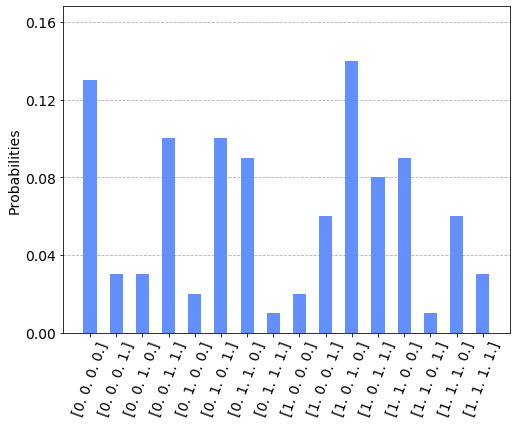

In [30]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 1, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

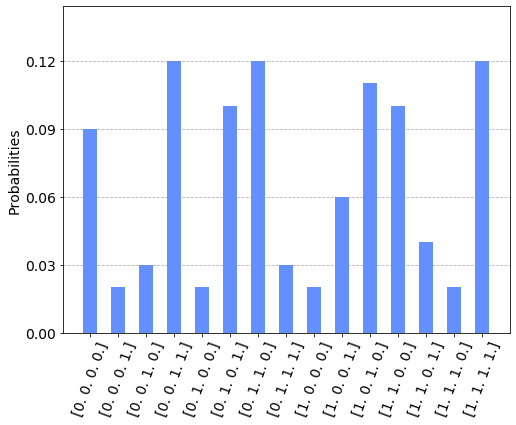

In [31]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 2, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

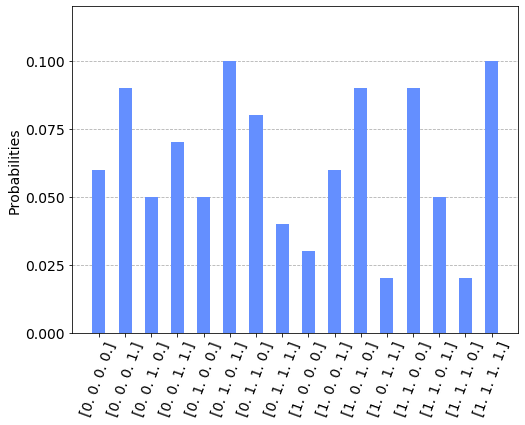

In [32]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 3, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

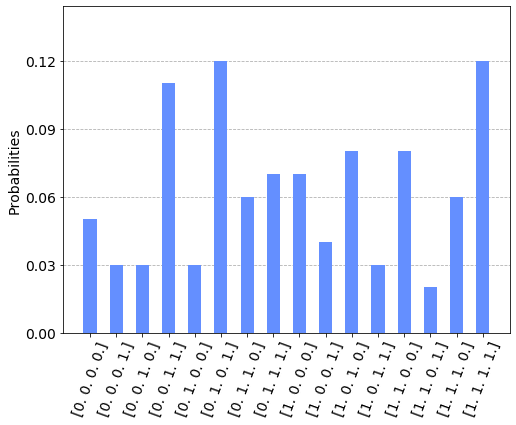

In [33]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 4, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

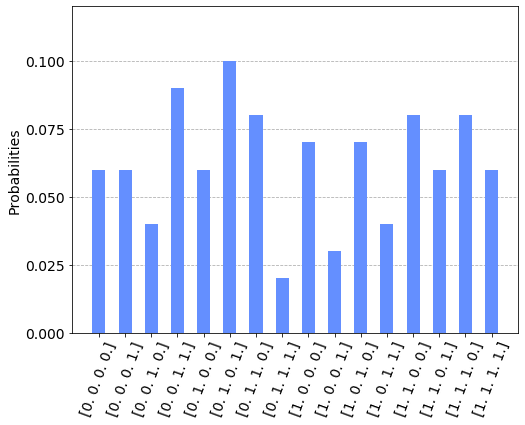

In [34]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 5, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

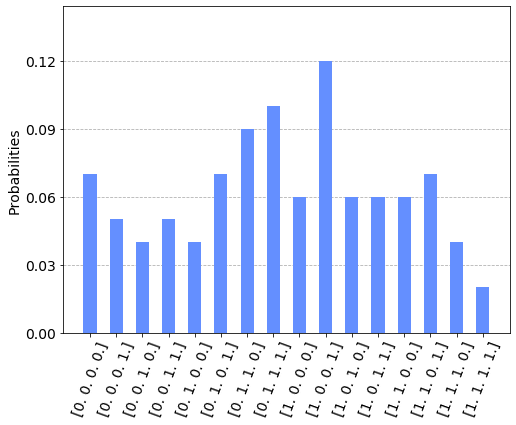

In [35]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 6, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

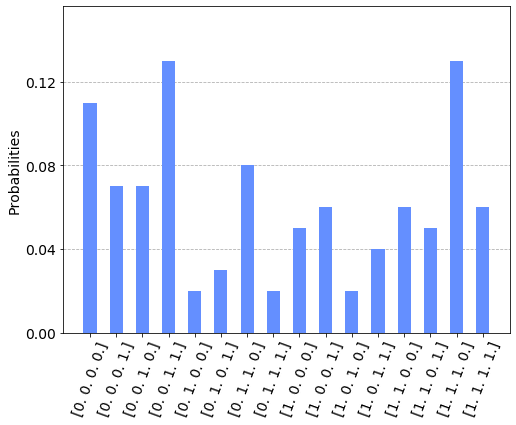

In [36]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 7, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

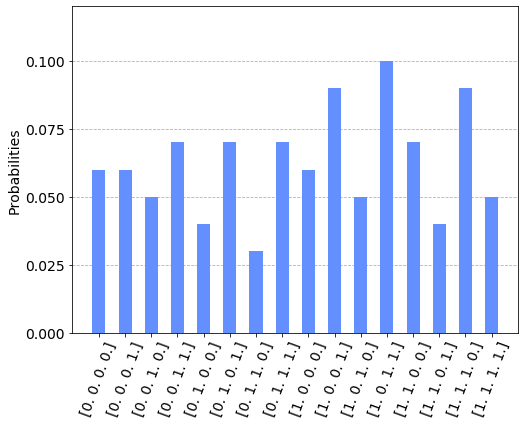

In [37]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 8, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

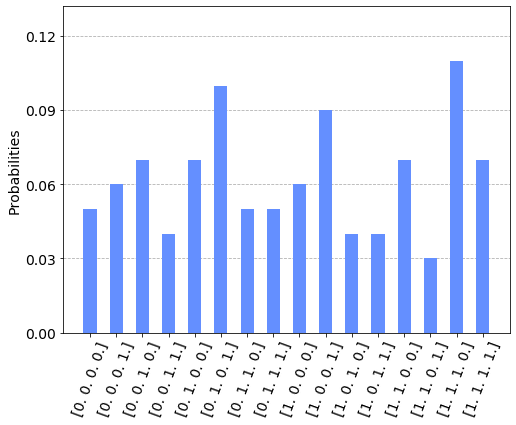

In [38]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 9, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

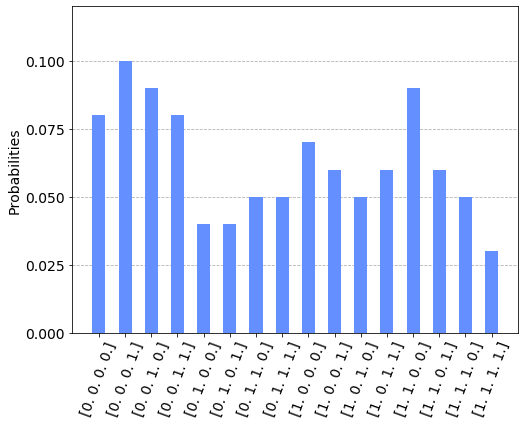

In [39]:
ks_results, ks_values, ks_weights, ks_expectation_ratios = qaoa_run(False, True, qubitOp, 10, 300, 1024, values, weights, classic_value, num_of_values, 100, False)

ks_results_counts = Counter(ks_results)

plot_histogram(ks_results_counts, figsize = (8,6), bar_labels = False)

In [40]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright